In [1]:
import pandas as pd
from random import choice
from ord_data_load import ORD_PATH, is_reaction_of_type, df_na_vals
from chem_render import draw_reaction, indigo
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


%load_ext autoreload
%autoreload 2

In [2]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

CPU times: total: 3.62 s
Wall time: 3.62 s


In [3]:
df_na_vals(df)

rxn_smiles        ->       Missing values: 0 (0.00%)
time              ->       Missing values: 545938 (50.57%)
temp              ->       Missing values: 855327 (79.23%)
temp_control      ->       Missing values: 810845 (75.11%)
yield             ->       Missing values: 637996 (59.10%)
patent            ->       Missing values: 0 (0.00%)
notes             ->       Missing values: 0 (0.00%)


[]

## Compare Suzuki substructure searches for USPTO database

In [4]:
SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"

In [8]:
%%time
rdkit_query = ReactionFromSmarts(SUZUKI_PATTERN)
suzuki_rdkit = df['rxn_smiles'][:10000].apply(is_reaction_of_type, args=(rdkit_query,))
suzuki_rdkit.sum()

CPU times: total: 5.17 s
Wall time: 5.18 s


167

In [9]:
# rdkit search

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_rdkit = dds.apply(is_reaction_of_type,
                         reaction_type_pattern=rdkit_query,
                         meta=pd.Series(dtype=bool)).compute(scheduler='processes') # rdkit functions are not parallelizable using "threads"
suzuki_rdkit.sum()

[########################################] | 100% Completed | 52.31 s
[########################################] | 100% Completed | 52.42 s


34539

In [10]:
# indigo search

query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    return True if indigo.substructureMatcher(indigo.loadReaction(rxn_smiles)).match(query) else False

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo = dds.apply(rxn_match,
                 # args=[query,),
                 # rxn_query=query,
                 meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo.sum()

[########################################] | 100% Completed | 149.91 s
[########################################] | 100% Completed | 150.00 s


32666

In [8]:
# indigo search using atom mapping in target reaction.

query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    return True if indigo.substructureMatcher(indigo.loadReaction(rxn_smiles), "DAYLIGHT-AAM").match(query) else False

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo_aam = dds.apply(rxn_match,
                          # args=[query,),
                          # rxn_query=query,
                          meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo_aam.sum()

[########################################] | 100% Completed | 149.66 s


32438

### Debug is_reaction_type

In [11]:
# from rdkit.Chem import MolFromSmiles as smiles2mol
#
# id = "ord-0bc171163cc04932b98554480b9c571f"
#
# reaction_to_test = df.loc[id, 'rxn_smiles']
# reactants = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[0].split('.'))))
# actual_products = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[-1].split('.'))))
#
# for r in reactants: display(r)
# for p in actual_products: display(p)


In [12]:
# SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"
# rdkit_query = ReactionFromSmarts(SUZUKI_PATTERN)
#
# print(is_reaction_of_type(reaction_to_test, rdkit_query))
# from copy import deepcopy
#
# reaction_type_pattern = rdkit_query
#
# if reaction_to_test is None:
#     print(False)
#
# if isinstance(reaction_to_test, str):
#     reactants = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[0].split('.'))))
#     actual_products = tuple(filter(None, (smiles2mol(smiles) for smiles in reaction_to_test.split(' ')[0].split('>')[-1].split('.'))))
#
# else:
#     reactants = reaction_to_test.GetReactants()
#     actual_products = reaction_to_test.GetProducts()
#
#
# if isinstance(reaction_type_pattern, str):
#     # use input string to make an RdKit reaction and molecules
#     reactants_patterns = tuple(smiles2mol(smiles) for smiles in reaction_type_pattern.split('>')[0].split('.'))
#     reaction_type_pattern = ReactionFromSmarts(reaction_type_pattern)
#
#
# # target reactants to be extracted from the target reaction
# reactants_patterns = reaction_type_pattern.GetReactants()
#
#
# reactants_to_test = []
# for r_pattern in reactants_patterns:
#     for r, reactant in enumerate(reactants):
#         if reactant is None:
#             continue
#         reactant.UpdatePropertyCache()
#         if reactant.HasSubstructMatch(r_pattern):
#             # the reactant matches with the pattern
#             reactants_to_test.append(deepcopy(reactant))
#             break # stop searching
#     else:
#         # no reactant in the input reaction matched with the pattern
#         print("no reactant in the input reaction matched with the pattern")
#
# for p in actual_products:
#     p.UpdatePropertyCache()
#
# estimated_products = []
# for product, *_ in reaction_type_pattern.RunReactants(reactants_to_test, maxProducts=10):
#     try:
#         product.UpdatePropertyCache()
#         estimated_products.append(product)
#     except:
#         pass
#
# if len(estimated_products) == 0:
#     print("len(estimated_products) == 0")
#
# print(any(any(pred.HasSubstructMatch(obs) for obs in actual_products)  # any of the actual products matches the predicted product
#            for pred in estimated_products))  # for any of the predicted products
#
# for pred in estimated_products:
#     display(pred)


In [13]:
# rxn_smarts = df.loc[id, 'rxn_smiles']
#
# print('rdkit ', is_reaction_of_type(
#     ReactionFromSmarts(rxn_smarts),
#     ReactionFromSmarts(SUZUKI_PATTERN))
# )
#
# if indigo.substructureMatcher(indigo.loadReaction(rxn_smarts)).match(query):
#     print('indigo', True)
# else:
#     print('indigo', False)

In [14]:
print("{indigo}          : ", suzuki_indigo.sum())
print("{rdkit}           : ", suzuki_rdkit.sum())
print("{indigo} - {rdkit}: ", (suzuki_indigo & ~suzuki_rdkit).sum())
print("{rdkit} - {indigo}: ", (suzuki_rdkit & ~suzuki_indigo).sum())
print("{rdkit} ∪ {indigo}: ", (suzuki_rdkit | suzuki_indigo).sum())
print("{rdkit} ∩ {indigo}: ", (suzuki_rdkit & suzuki_indigo).sum())

{indigo}          :  32666
{rdkit}           :  34539
{indigo} - {rdkit}:  2841
{rdkit} - {indigo}:  4714
{rdkit} ∪ {indigo}:  37380
{rdkit} ∩ {indigo}:  29825


In [15]:
unique_rdkit = df[suzuki_rdkit & ~suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_16636\415057053.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_rdkit = df[suzuki_rdkit & ~suzuki_indigo]


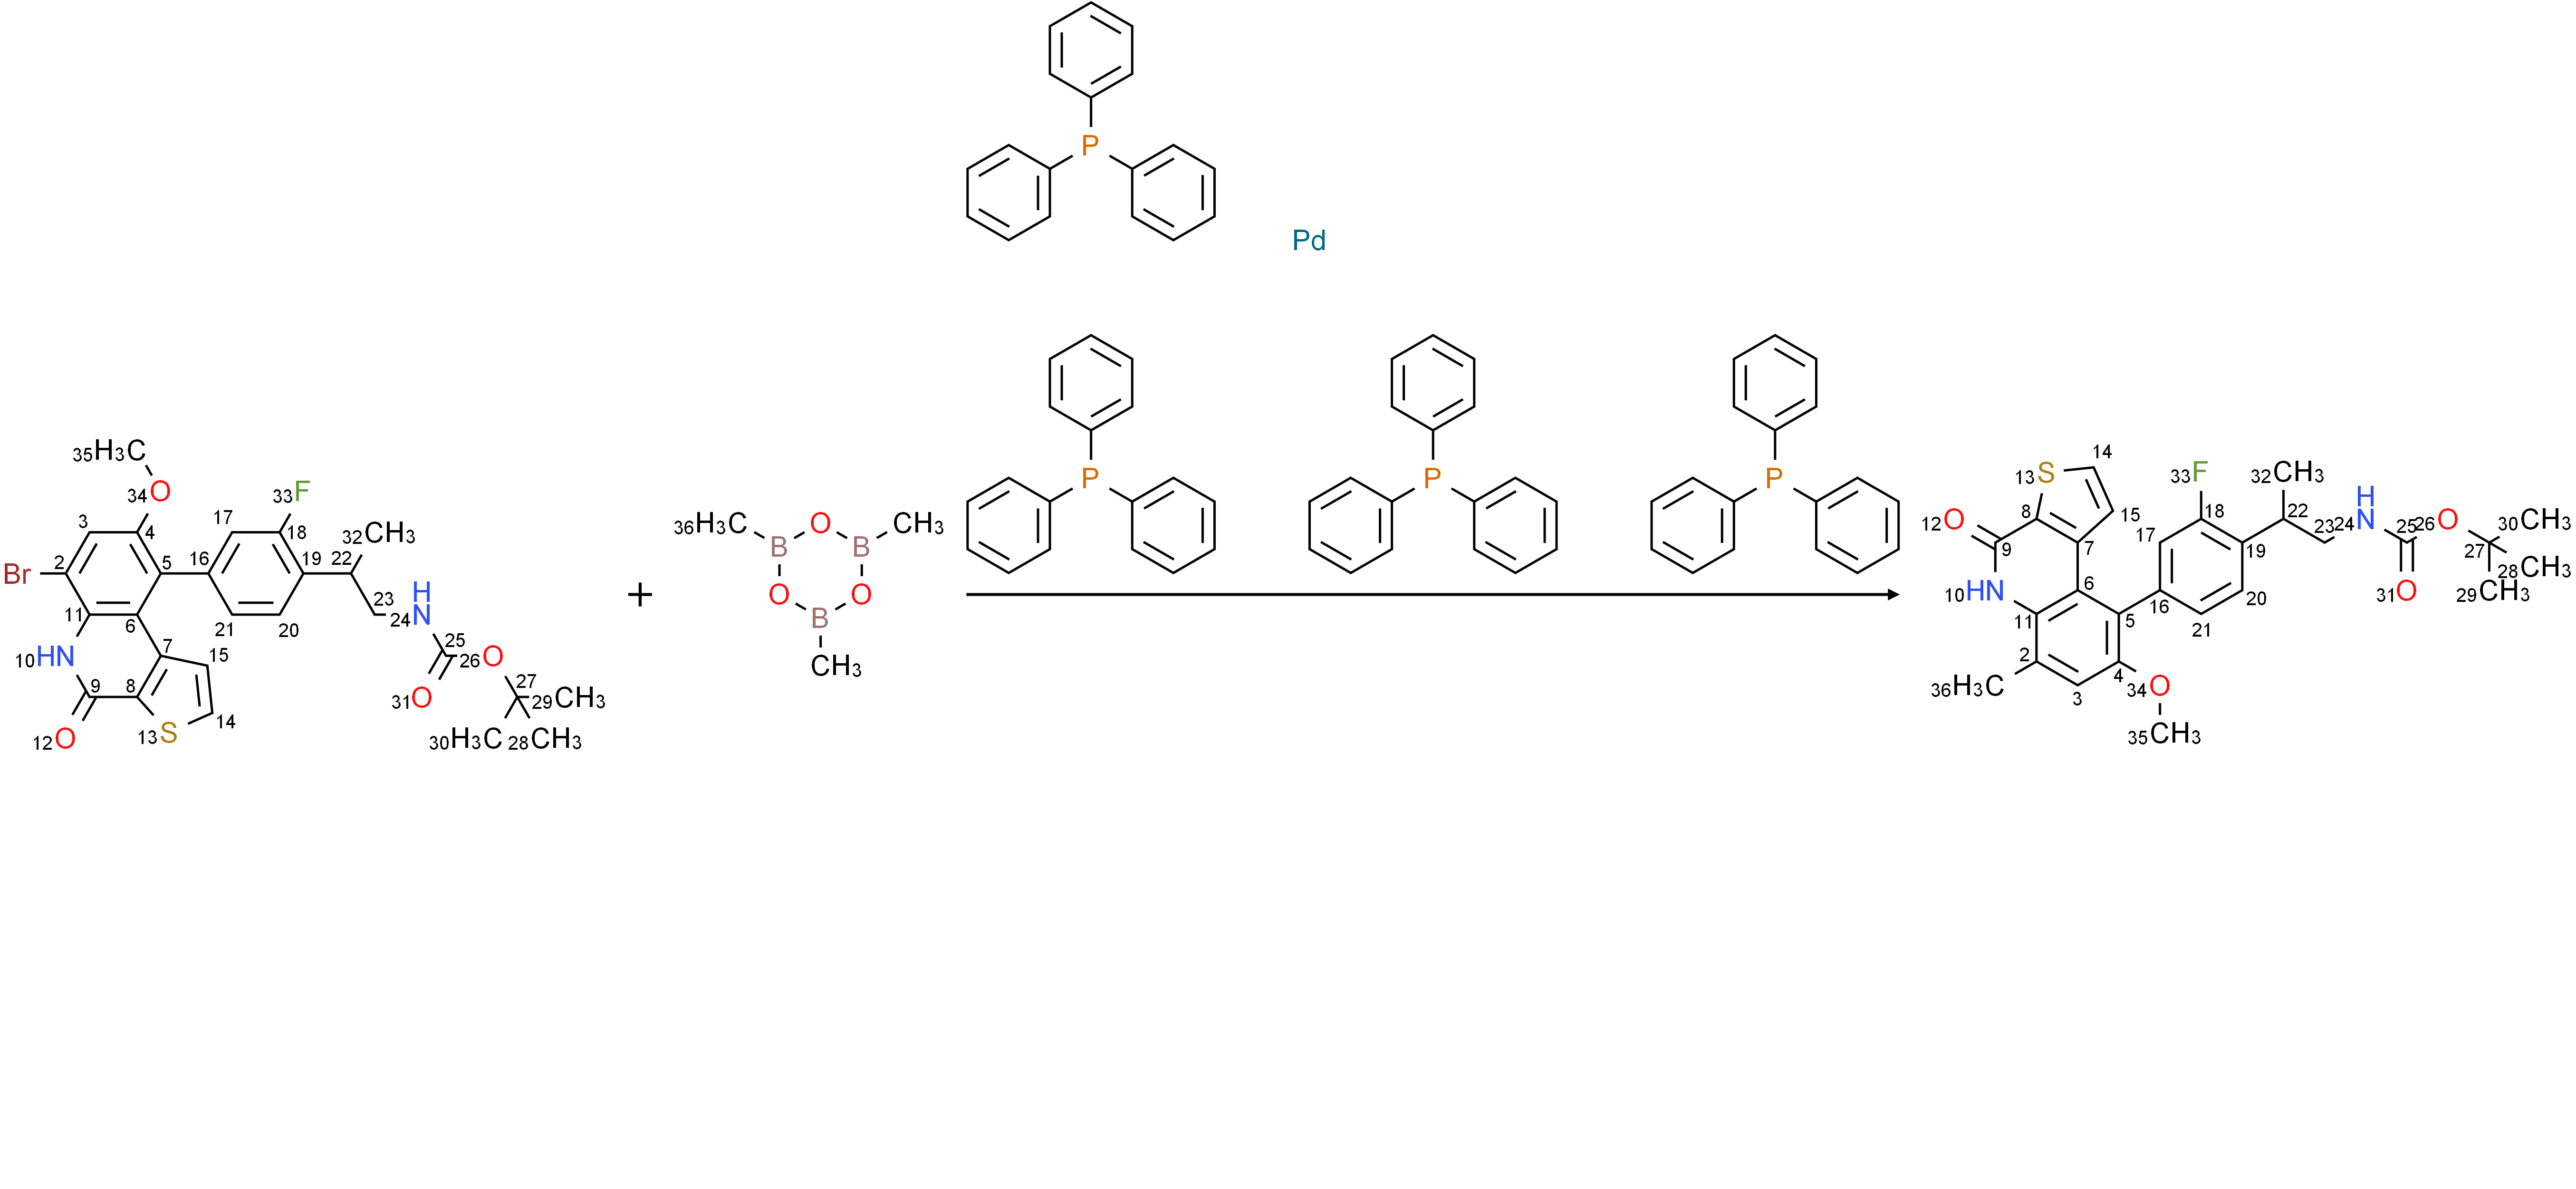

Set size:         4714
Patent:           US08962648B2
Reaction_id:      ord-8805a4bf40c644b596661f28202a411a
Following General Procedure I, tert-butyl 2-(4-(6-bromo-8-methoxy-4-oxo-4,5-dihydrothieno[2,3-c]quinolin-9-yl)-2-fluorophenyl)propylcarbamate (282 mg, 0.50 mmol) was reacted with trimethylboroxine (170 mg, 1.35 mmol) and Pd(pph3)4 (50 mg, 0.04 mmol) to afford the desired product (130 mg, 52%) as a yellow solid. ESI MS m/z 497 [C27H29FN2O4S+H]+.
CPU times: total: 703 ms
Wall time: 710 ms


'ord-8805a4bf40c644b596661f28202a411a'

In [33]:
%%time
# unique to rdkit
draw_reaction(unique_rdkit)

In [34]:
unique_indigo = df[suzuki_indigo & ~suzuki_rdkit]

C:\Users\ergot\AppData\Local\Temp\ipykernel_16636\3555911165.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_indigo = df[suzuki_indigo & ~suzuki_rdkit]


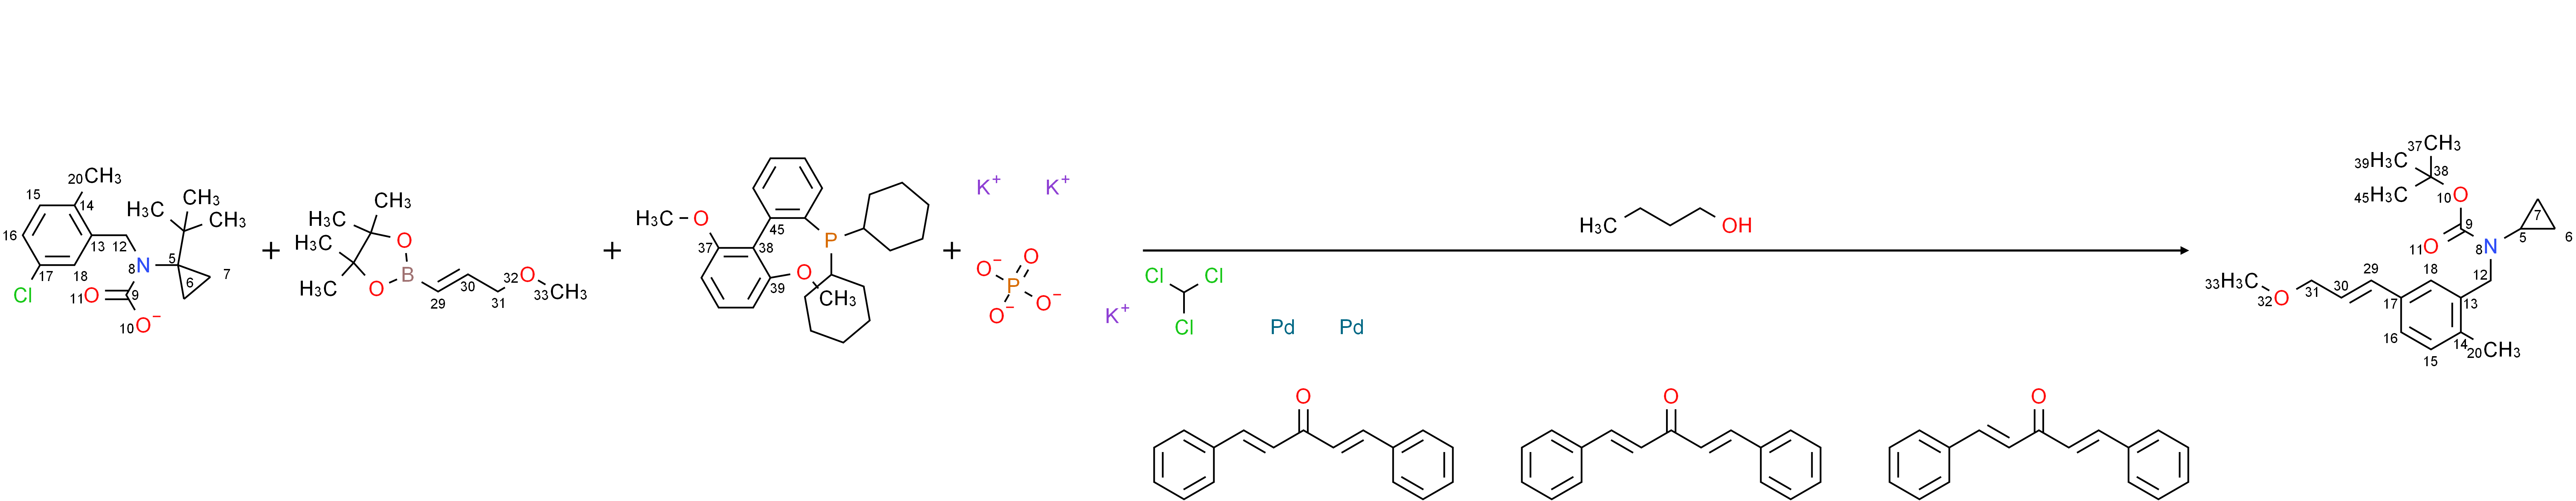

Set size:         2841
Patent:           US08889714B2
Reaction_id:      ord-d668d311f5e947deb6a4a6bdd15e946f
1,1-Dimethylethyl[(5-chloro-2-methylphenyl)methyl]cyclopropylcarbamate (1 eq.) from the previous step and 4,4,5,5-tetramethyl-2-[(1E)-3-(methyloxy)-1-propen-1-yl]-1,3,2-dioxaborolane (1 eq.) were combined in n-BuOH (0.48 M). To this solution was then added tris(dibenzylideneacetone)dipalladium(0) chloroform adduct (0.02 eq.), [2′,6′-bis(methyloxy)-2-biphenylyl](dicyclohexyl)phosphane (0.08 eq.) and powdered potassium phosphate (2 eq.). The vessel was repeatedly evacuated and back-filled with nitrogen before the resulting suspension was heated at 100° C. for 16 h. The now black suspension was cooled to RT, diluted with EtOAc and filtered through a pad of SiO2. The filtrate was then concentrated in vacuo and the crude product thus obtained was directly subjected to purification by way of flash chromatography (SiO2, Hex→3:7 (v/v) Hex:EtOAc). The title compound was isolated as a pal

'ord-d668d311f5e947deb6a4a6bdd15e946f'

In [46]:
# unique to indigo
draw_reaction(unique_indigo)

In [19]:
# union of {rdkit} and {indigo} subsets
suzuki_df = df[suzuki_rdkit | suzuki_indigo]

C:\Users\ergot\AppData\Local\Temp\ipykernel_16636\728856817.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  suzuki_df = df[suzuki_rdkit | suzuki_indigo]


In [20]:
%%time
suzuki_df.to_pickle(f"{ORD_PATH}/suzuki_rxn.pkl.zst")

CPU times: total: 312 ms
Wall time: 303 ms


In [3]:
suzuki_df = pd.read_pickle(f"{ORD_PATH}/suzuki_rxn.pkl.zst")
choice(suzuki_df.rxn_smiles)

'[F:1][C:2]([F:31])([F:30])[C:3]1[CH:4]=[C:5]([C@H:13]2[O:17][C:16](=[O:18])[N:15]([CH2:19][C:20]3[C:25](Br)=[CH:24][N:23]=[C:22]([S:27][CH3:28])[N:21]=3)[C@H:14]2[CH3:29])[CH:6]=[C:7]([C:9]([F:12])([F:11])[F:10])[CH:8]=1.[CH:32]([C:35]1[CH:36]=[C:37](B(O)O)[C:38]([O:41][CH3:42])=[N:39][CH:40]=1)([CH3:34])[CH3:33].C([O-])([O-])=O.[K+].[K+].[NH4+].[Cl-]>C(OCC)(=O)C.[Pd](Cl)Cl.C(P(C(C)(C)C)[C-]1C=CC=C1)(C)(C)C.[C-]1(P(C(C)(C)C)C(C)(C)C)C=CC=C1.[Fe+2]>[F:1][C:2]([F:31])([F:30])[C:3]1[CH:4]=[C:5]([C@H:13]2[O:17][C:16](=[O:18])[N:15]([CH2:19][C:20]3[C:25]([C:37]4[C:38]([O:41][CH3:42])=[N:39][CH:40]=[C:35]([CH:32]([CH3:34])[CH3:33])[CH:36]=4)=[CH:24][N:23]=[C:22]([S:27][CH3:28])[N:21]=3)[C@H:14]2[CH3:29])[CH:6]=[C:7]([C:9]([F:12])([F:11])[F:10])[CH:8]=1 |f:2.3.4,5.6,8.9.10.11|'

In [21]:
suzuki_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37380 entries, ord-205c29c6463642c4a3ef2726db5ff6fc to ord-7e9dca83f617441ea03c8f72561a3acb
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rxn_smiles    37380 non-null  object  
 1   time          8654 non-null   float64 
 2   temp          16246 non-null  float64 
 3   temp_control  2823 non-null   category
 4   yield         17772 non-null  float64 
 5   patent        37380 non-null  category
 6   notes         37380 non-null  object  
dtypes: category(2), float64(3), object(2)
memory usage: 2.9+ MB


In [24]:
%%time
cmpds = pd.read_pickle(f'{ORD_PATH}/uspto_cmpd.pkl.zst')

CPU times: total: 3.64 s
Wall time: 3.65 s


In [25]:
%%time
suzuki_cmpd = cmpds.loc[suzuki_df.index]

CPU times: total: 1.25 s
Wall time: 1.24 s


In [26]:
suzuki_cmpd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230979 entries, ord-205c29c6463642c4a3ef2726db5ff6fc to ord-7e9dca83f617441ea03c8f72561a3acb
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   trivial   29466 non-null   object
 1   name      230979 non-null  object
 2   smiles    224654 non-null  object
 3   rxn_role  230979 non-null  object
dtypes: object(4)
memory usage: 8.8+ MB


In [27]:
suzuki_cmpd.shape

(230979, 4)

In [47]:
%%time
suzuki_cmpd.to_pickle(f"{ORD_PATH}/suzuki_cmpd.pkl.zst")

CPU times: total: 344 ms
Wall time: 343 ms


### Find Pd catalyst

In [50]:
mask = suzuki_cmpd.name.str.contains(r'Pd|[Pp]all?ad')
mask.sum()

25449

In [53]:
pd_cat = suzuki_cmpd[mask]
pd_cat.name.value_counts()

Pd(PPh3)4                                                                             3465
tetrakis(triphenylphosphine)palladium(0)                                              2683
tetrakis(triphenylphosphine)palladium                                                 1832
Pd(dppf)Cl2                                                                           1154
PdCl2(dppf)                                                                            949
                                                                                      ... 
dichloro[1,1′-bis(diphenyl-phosphino)ferrocene]palladium(II) dichloromethane             1
Dichloro[1,1′-bis(diphenylphosphino)ferrocene]palladium(II)dichloromethane               1
dichloro[1,1′-bis(diphenylphoshino)ferrocene]-palladium(II) dichloromethane adduct       1
1,1′-bis(diphenylphosphino)ferrocenepalladium (ii) dichloride                            1
Dichlorobis(triphenylphosphine)palladium(III)                                            1

In [56]:
suzuki_df.loc[pd_cat.index]

,rxn_smiles,time,temp,temp_control,yield,patent,notes
ord-205c29c6463642c4a3ef2726db5ff6fc,[CH3:1][N:2]1[CH:6]=[C:5](I)[CH:4]=[C:3]1[C:8]...,0.333333,NaN,AMBIENT,47.000000,US05723499,231 mg (0.2 mml) of tetrakis-(triphenylphosphi...
ord-eb2559d3fc404f17a5ecee988d37d685,[C:1]1([CH3:10])[CH:6]=[CH:5][C:4](B(O)O)=[CH:...,NaN,NaN,NaN,77.400002,US05726319,A vigorously stirred mixture of 34 g (0.25 mol...
ord-03e5f7ccfb154de09af0ec7af5397bc8,[CH2:1]([CH:9]1[CH2:17][C:16]2[C:11](=[CH:12][...,NaN,NaN,NaN,22.500000,US05733476,"Under nitrogen atmosphere, 0.30 g (1.09 mM) of..."
ord-f04c2e1d91b841f084faee8cc1432b9f,Br[C:2]1[CH:3]=[N:4][CH:5]=[C:6]([Br:8])[CH:7]...,NaN,NaN,AMBIENT,NaN,US05733912,"Portions of 3,5-dibromopyridine (1.0 g, 4.22 m..."
ord-46152c9e14d74da38cf75a60bb4c02b6,C(=O)([O-])[O-].[K+].[K+].Br[C:8]1[CH:13]=[CH:...,NaN,60.0,NaN,65.000000,US05245035,"A mixture of potassium carbonate (5.8 g), 5-(2..."
...,...,...,...,...,...,...,...
ord-aa0c3881530e45b891d634386c3fc0d6,[CH3:1][O:2][C:3]([C:5]1[C@@H:6]2[N:20]([C:21]...,NaN,NaN,AMBIENT,89.000000,US07968720B2,"To a sol. of compound A1 (10.0 g, 24.1 mmol) a..."
ord-7104ad02ea224b4daa9864b15315c645,[CH3:1][O:2][C:3]([C:5]1[CH2:6][N:7]([C:19]([O...,1.000000,80.0,NaN,40.000000,US07968720B2,"A mixture of 4-trifluoromethanesulfonyloxy-5,6..."
ord-8fcea0fde9c547858f3300d88722485c,[CH2:1]([O:3][C:4]([C:6]1[C@@H:7]2[N:22]([CH3:...,1.000000,80.0,NaN,81.000000,US07968720B2,"(rac.)-(1R*,5S*)-9-Methyl-7-trifluoromethanesu..."
ord-424d602ee6b34dcab5e37c9aa19aab48,[CH3:1][O:2][C:3]([C:5]1[C@@H:6]2[N:21]([C:22]...,1.000000,80.0,NaN,73.000000,US07968720B2,"(rac.)-(1R*,5S*)-7-Trifluoromethanesulfonyloxy..."
